## Семинар 2 "Распознавание рукописных цифр"

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [1]:
#Реализация двухслойной нейронной сети

import torch
from torch.autograd import Variable

N, D_in, D_out = 64, 1000, 10
H = 100

x = Variable(torch.randn(N, D_in))
y = Variable(torch.randn(N, D_out), requires_grad=False)

model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.Sigmoid(),
          torch.nn.Linear(H, D_out)
        )

loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

learning_rate = 1e-3
for t in range(500):
    y_pred = model(x)

    loss = loss_fn(y_pred, y)
    if t%50 == 0:
        print(t, loss.data[0])
        

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

0 766.9312744140625
50 241.1732635498047
100 139.49203491210938
150 87.7652359008789
200 56.96977996826172
250 37.48241424560547
300 24.823396682739258
350 16.495113372802734
400 10.961907386779785
450 7.249002456665039


# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score
%matplotlib inline

In [3]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
X_test = test_dataset.test_data.view(test_dataset.test_data.size(0), -1)
y_test = test_dataset.test_labels.numpy()


In [5]:
D_in, H, D_out = 784, 300, 10


def predict(model, x_val):
    
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy().argmax(axis=1)


model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.Sigmoid(),
          torch.nn.Linear(H, H),
          torch.nn.Sigmoid(),
          torch.nn.Linear(H, D_out)
        )

loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(5):
    flag = []
    for X, Y in train_loader:
        
        X = X.view(X.size(0), -1)
        #print (X.size())
        x = Variable(X, requires_grad=False)
        y = Variable(Y, requires_grad=False)

        y_pred = model.forward(x)

        #loss = -loss_fn(y_pred, y)
        #print(t, loss.data[0])
        loss =  loss_fn(y_pred, y)
        flag.append(loss.data[0])
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    print (t, np.array(flag).mean())

    X_test = X_test.type(torch.FloatTensor)
    print (accuracy_score(predict(model, X_test), y_test))
        
        



0 0.296879662329
0.9503
1 0.10537162516
0.9389
2 0.0682402932341
0.9217
3 0.0507400055861
0.9135
4 0.0407628000321
0.8901


## Задание

Используя датасет с особенными точками лица из лекции, разбейте данные на train / test и решите задачу регрессии для поиска 15-ти особых точек. Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

Image name: 1053.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 10.  45.]
 [  9.  55.]
 [  9.  65.]
 [ 10.  76.]]


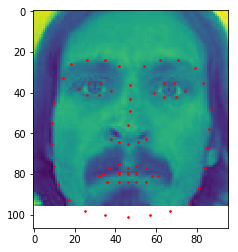

In [3]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
from torch.autograd import Variable

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('Seminar 3(1)/dataset/train/face_landmarks.csv')

n = 60
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('Seminar 3(1)/dataset/train/', img_name)),
               landmarks)
plt.show()


In [4]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        #image = image.transpose((0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [5]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
crop = RandomCrop(90)
composed = transforms.Compose([RandomCrop(90)])

In [7]:
transformed_dataset = FaceLandmarksDataset(csv_file='Seminar 3(1)/dataset/train/face_landmarks.csv',
                                           root_dir='Seminar 3(1)/dataset/train/', transform=transforms.Compose([
                                               RandomCrop(90),
                                               ToTensor()
                                           ])
                                           )

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].float().size(), sample['landmarks'].float().size())
 
    if i == 3:
        plt.show()

        break

0 torch.Size([90, 90]) torch.Size([68, 2])
1 torch.Size([90, 90]) torch.Size([68, 2])
2 torch.Size([90, 90]) torch.Size([68, 2])
3 torch.Size([90, 90]) torch.Size([68, 2])


In [8]:
dataloader = DataLoader(transformed_dataset, batch_size=40,
                        shuffle=True, num_workers=4)




In [11]:
D_in, H, D_out = 90*90, 330, 136


def predict(model, x_val):
    
    x = Variable(x_val, requires_grad=False)
    output = model.forward(x)
    return output.data.numpy()


model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ELU(),
          #torch.nn.Linear(H, H),
          #torch.nn.Sigmoid(),
          torch.nn.Linear(H, D_out)
        )

#loss_fn = torch.nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
loss_fn = torch.nn.MSELoss(size_average=True)

learning_rate = 1e-4/2

optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(200):
    flag = []
    k=0
    for T in dataloader:
        
        k+=1
        X = T['image'].view(T['image'].size(0), -1).float()
        Y = T['landmarks'].view(T['landmarks'].size(0), -1).float()
        x = Variable(X, requires_grad=False)
        y = Variable(Y, requires_grad=False)

        y_pred = model.forward(x)

        #loss = -loss_fn(y_pred, y)
        #print(t, loss.data[0])
        loss =  loss_fn(y_pred, y)
        flag.append(loss.data[0])
        #print (loss.data[0])
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    print ('epoch %d, meanerror %f' % (t, np.array(flag).mean()))

    #X_test = X_test.type(torch.FloatTensor)
    #print (accuracy_score(predict(model, X_test), y_test))
        
        

epoch 0, meanerror 64791.879746
epoch 1, meanerror 1964.380940
epoch 2, meanerror 1822.002326
epoch 3, meanerror 1690.575930
epoch 4, meanerror 1568.115117
epoch 5, meanerror 1455.118328
epoch 6, meanerror 1350.271079
epoch 7, meanerror 1253.166923
epoch 8, meanerror 1162.921693
epoch 9, meanerror 1079.277737
epoch 10, meanerror 1001.956318
epoch 11, meanerror 929.899526
epoch 12, meanerror 863.906583
epoch 13, meanerror 802.247071
epoch 14, meanerror 744.792459
epoch 15, meanerror 691.752339
epoch 16, meanerror 642.631511
epoch 17, meanerror 597.352886
epoch 18, meanerror 555.128387
epoch 19, meanerror 515.865893
epoch 20, meanerror 479.617273
epoch 21, meanerror 446.210561
epoch 22, meanerror 414.867381
epoch 23, meanerror 386.084073
epoch 24, meanerror 359.376764
epoch 25, meanerror 334.511787
epoch 26, meanerror 311.668068
epoch 27, meanerror 290.344896
epoch 28, meanerror 270.537160
epoch 29, meanerror 252.288333
epoch 30, meanerror 235.435290
epoch 31, meanerror 219.535476
epoch 

In [12]:
tr_data_test = FaceLandmarksDataset(csv_file='Seminar 3(1)/dataset/test/face_landmarks.csv',
                                           root_dir='Seminar 3(1)/dataset/test/', transform=transforms.Compose([
                                               RandomCrop(90),
                                               ToTensor()
                                           ])
                                           )

In [13]:
import warnings
warnings.filterwarnings("ignore")

landmarks_frame = pd.read_csv('Seminar 3(1)/dataset/test/face_landmarks.csv')

#n = 60
#img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)


def plt_test(i):   
    landmarks = landmarks_frame.ix[i, 1:].as_matrix().astype('float')
    landmarks = landmarks.reshape(-1, 2)
    plt.figure()
    a = tr_data_test[i]['image'].float()
    a = a.view(-1)
    f = predict(model, a)
    f_1 = f[::2]
    f_2 = f[1::2]
    img_name = landmarks_frame.ix[i, 0]
    plt.figure()
    plt.imshow(io.imread(os.path.join('Seminar 3(1)/dataset/test/', img_name)))
    plt.scatter(f_1, f_2, s = 10, c= 'b')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')

    

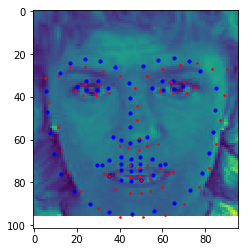

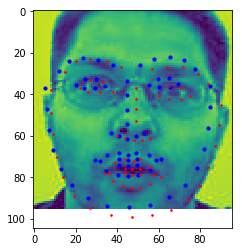

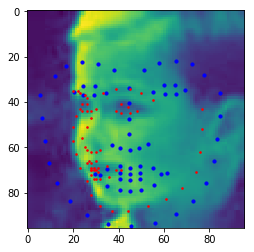

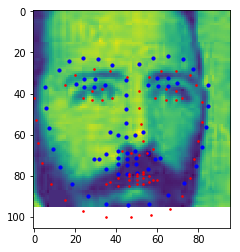

In [15]:
#Нарисуем, что получилось
plt_test(1)
plt_test(2)
plt_test(30)
plt_test(50)